# Gemini API とオープンソースによる動画処理・動画分析の手法

このハンズオンでは、Gemini による動画分析に加えて、オープンソースを利用した動画処理の手法を学びます。

具体的には、次のオープンソースを用いて、動画の前処理と動体検知を行います。

- moviepy：動画の前処理（タイムコードの焼きつけとファイルサイズの調整）
- opencv：動体検知（動きのある区間の検出）

その後、動きの無い区間と動きのある区間を個別に Gemini API で分析します。

動きの無い区間は動画ファイルの代わりに、区間の開始時点・終了時点の静止画のみを用いることで、Gemini API に入力するトークン数を減らして分析時間を短縮します。

## 事前準備

### パッケージインストール

In [ ]:
%pip install --upgrade \
    opencv-python  \
    opencv-contrib-python \
    moviepy

インストールしたパッケージを利用可能にするためにカーネルを再起動します。

In [2]:
import IPython
app = IPython.Application.instance()
_ = app.kernel.do_shutdown(True)

### モジュールのインポートと初期設定

In [1]:
import copy, json, os, pprint, tempfile, threading, time, uuid
import cv2
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
from IPython.display import Video
from moviepy import VideoFileClip, TextClip, CompositeVideoClip, VideoClip, ColorClip

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

from google.cloud import storage

import vertexai
from google import genai
from google.genai.types import (
    HttpOptions, GenerateContentConfig, Part, Content
)

[PROJECT_ID] = !gcloud config list --format 'value(core.project)'
LOCATION = 'us-central1'

vertexai.init(
    project=PROJECT_ID,
    location=LOCATION,
)

BUCKET_NAME = f'{PROJECT_ID}_video_files'

### ストレージバケット作成

In [2]:
result = !gsutil ls gs://{BUCKET_NAME}
if result and result[0].startswith('BucketNotFoundException'):
    !gsutil mb -b on -l {LOCATION} gs://{BUCKET_NAME}

In [24]:
!wget -q -O room_camera_example.mov \
https://raw.githubusercontent.com/google-cloud-japan/sa-ml-workshop/main/video-analysis-handson/movie_files/room_camera_example.mov

upload_blob('room_camera_example.mov', 'original/room_camera_example.mov')

## 補助関数の定義

### ファイルをストレージバケットにアップロード・ダウンロードする関数

In [3]:
def upload_blob(source_path, destination_path, bucket_name=BUCKET_NAME):
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_path)
    blob.upload_from_filename(source_path)
    
def download_blob(source_path, destination_path, bucket_name=BUCKET_NAME): 
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_path)
    blob.download_to_filename(destination_path)

### Gemini API でコンテンツを分析する関数

In [4]:
def analyze_content(system_instruction, contents,
                    response_schema, temperature=0.1,
                    model='gemini-2.5-flash'):
    client = genai.Client(vertexai=True,
                          project=PROJECT_ID, location=LOCATION,
                          http_options=HttpOptions(api_version='v1'))
    response = client.models.generate_content(
        model=model,
        contents=contents,
        config=GenerateContentConfig(
            system_instruction=system_instruction,
            temperature=temperature,
            top_p=0.5,
            response_mime_type='application/json',
            response_schema=response_schema,
        )
    )
    result_text = '\n'.join(
        [p.text for p in response.candidates[0].content.parts if p.text]
    )
    return json.loads(result_text)

### 動体検知の結果をヒートマップにビジュアライズする関数

In [5]:
def show_heatmap(active_rate, event_list):
    base_time = event_list[0]['start_time']
    unusual_periods = []
    for event in event_list:
        if event['status'] == 'unusual':
            start_time = event['start_time'] - base_time
            end_time = event['end_time'] - base_time
            unusual_periods.append((start_time, end_time))

    original_data = np.array(active_rate)
    smooth_length = 400
    x_original = np.linspace(0, 1, len(original_data))
    x_smooth = np.linspace(0, 1, smooth_length)
    data_smooth = np.interp(x_smooth, x_original, original_data)
    data_2d = data_smooth.reshape(1, -1)

    plt.figure(figsize=(10, 0.5))
    ax = plt.gca()
    sns.heatmap(data_2d, annot=False, cmap='Blues', vmax=100, cbar=False)#, fmt='d')
    plt.yticks([])
    plt.ylabel('')
    plt.xticks([])
    plt.xlabel('')    
    tick_positions = np.linspace(0, smooth_length - 1, num=len(original_data))
    for (start_time, end_time) in unusual_periods:
        x1 = tick_positions[start_time]
        x2 = tick_positions[end_time]
        box_width = x2 - x1
        rect = patches.Rectangle(
            (x1, 0), box_width, 0.95,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
    plt.xticks(ticks=tick_positions, labels=np.arange(len(original_data)))
    plt.xlabel('Seconds')
    return unusual_periods

## 動画の前処理

動画にタイムコードを焼き付けて、ファイルサイズを圧縮します。

In [6]:
def add_timestamp_overlay(
    video_path,
    output_path,
    video_start_datetime='2025-01-01 00:00:00', 
):
    with tempfile.TemporaryDirectory() as temp_dir:

        video_source = os.path.join(temp_dir, video_path)
        video_dest = os.path.join(temp_dir, output_path)

        dirname, _ = os.path.split(video_source)
        if dirname:
            os.makedirs(dirname, exist_ok=True)
        dirname, _ = os.path.split(video_dest)
        if dirname:
            os.makedirs(dirname, exist_ok=True)

        download_blob(video_path, video_source)

        # Parse the start time
        start_datetime = datetime.strptime(
            video_start_datetime, '%Y-%m-%d %H:%M:%S'
        )

        # Load video and resize it
        video = VideoFileClip(video_source).resized(width=640)

        # Background of timecode area
        bg_clip = (
            ColorClip(
            size=(225, 38),   # Timecode area size
            color=(0, 0, 0),  # Black color
                duration=video.duration,
            )
            .with_opacity(0.5)
            .with_position(('left', 'top'))
        )

        # Timecode clips
        text_clips = []
        total_seconds = int(video.duration)

        for i in range(total_seconds + 1):
            current_time = start_datetime + timedelta(seconds=i)
            timestamp_text = current_time.strftime('%Y-%m-%d %H:%M:%S')

            clip_duration = 1.0
            if i == total_seconds: # Last clip might be shorter
                clip_duration = video.duration - total_seconds
                if clip_duration <= 0:
                    continue

            txt = (
                TextClip(
                    text=timestamp_text,
                    font_size=19,
                    color='white',
                    font='DejaVuSans',
                    method='label',
               )
               .with_duration(clip_duration)
               .with_start(i)
               .with_position((10, 12))
            )
            text_clips.append(txt)

        # Merge all clips
        all_clips = [video, bg_clip] + text_clips
        final_video = CompositeVideoClip(all_clips)

        # Write the result with optimized settings
        if video.audio is None:
            final_video.write_videofile(
                video_dest,
                codec='libx264',
                preset='faster',
                threads=os.cpu_count(),
                audio=False,
                remove_temp=True,
                # logger=None,  # Suppress moviepy's verbose output
            )
        else:
            with tempfile.TemporaryDirectory() as temp_dir:
                final_video.write_videofile(
                  video_dest,
                  codec='libx264',
                  preset='faster',
                  threads=os.cpu_count(),
                  audio_codec='libvorbis',
                  # temp_audiofile should be in tmpdir
                  temp_audiofile=os.path.join(temp_dir, 'temp-audio.ogg'),
                  remove_temp=True,
                  # logger=None,  # Suppress moviepy's verbose output
                )

        upload_blob(video_dest, output_path)
        
        # Cleanup
        for item in all_clips:
            item.close()
        final_video.close()

    return video_start_datetime

### 実行例

In [7]:
original_video_path = 'original/room_camera_example.mov'
processed_video_path = 'processed/room_camera_example.mp4'
video_start_datetime = add_timestamp_overlay(
    original_video_path,
    processed_video_path,
)

video_start_datetime

MoviePy - Building video /var/tmp/tmpbw8toxuy/processed/room_camera_example.mp4.
MoviePy - Writing audio in /var/tmp/tmpe9rlcmud/temp-audio.ogg


MoviePy - Done.
MoviePy - Writing video /var/tmp/tmpbw8toxuy/processed/room_camera_example.mp4



MoviePy - Done !
MoviePy - video ready /var/tmp/tmpbw8toxuy/processed/room_camera_example.mp4


'2025-01-01 00:00:00'

#### 前処理実行後の動画を確認

In [8]:
tmpfile = f'/tmp/tmp_movie_{uuid.uuid4()}.mp4'
download_blob(processed_video_path, tmpfile)
Video(tmpfile, embed=True, width=480)

## 動体検知処理

動画を 1 秒毎の区間に分けて、画面の 0.5% 以上の部分に移動物体が存在する区間を検知します。

In [9]:
def detect_motion_events(video_path):
    sampling_fps = 1
    mog2_history = 500
    mog2_var_threshold = 16
    
    with tempfile.TemporaryDirectory() as temp_dir:
        video_source = os.path.join(temp_dir, video_path)
        dirname, _ = os.path.split(video_source)
        if dirname:
            os.makedirs(dirname, exist_ok=True)
        download_blob(video_path, video_source)
        
        cap = cv2.VideoCapture(video_source)

        fps = cap.get(cv2.CAP_PROP_FPS)
        assert(sampling_fps <= fps)
        frame_skip_interval = max(1, int(round(fps / sampling_fps)))
        print(
            f"Video FPS: {fps}, Sampling FPS: {sampling_fps}, Frame Skip Interval: {frame_skip_interval}"
        )

        # Initialize MOG2 background subtractor
        fgbg_mog2 = cv2.createBackgroundSubtractorMOG2(
            history=mog2_history, varThreshold=mog2_var_threshold, detectShadows=True
        )

        mog2_motion_timestamps = []
        active_rate_list = []
        frame_count = -1
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        for _ in tqdm(
            range(total_frames), desc="Processing video frames", unit="frames"
        ):
            frame_count += 1
            ret, frame = cap.read()
            if not ret:
                break

            # Process with sampling_fps
            if frame_count % frame_skip_interval != 0:
                continue

            # Apply MOG2 to get foreground mask
            fgmask_mog2 = fgbg_mog2.apply(frame)
            fgmask_mog2 = cv2.morphologyEx(fgmask_mog2, cv2.MORPH_OPEN, kernel)
            fgmask_mog2 = cv2.morphologyEx(fgmask_mog2, cv2.MORPH_CLOSE, kernel)

            # Check if moving objects occupy more than 0.5% of the entire screen
            mog2_motion_pixels = cv2.countNonZero(fgmask_mog2)
            active_rate = (mog2_motion_pixels * 100) / (frame.shape[0] * frame.shape[1])
            current_time = frame_count / fps

            if active_rate > 0.5:
                mog2_motion_timestamps.append(current_time)

            if current_time == 0:
                active_rate = 0
            active_rate_list.append(active_rate)

        cap.release()
        video_duration = total_frames / fps if fps > 0 else 0.0

    return {
        "video_duration": video_duration,
        "event_timestamp": mog2_motion_timestamps,
        "active_rate": active_rate_list,
    }

### 実行例

以下の情報が得られます。

- `event_timestamp` : 0.5% 以上の部分に移動物体が存在する時刻（秒）
- `active_rate`: 1 秒毎に画面上に移動物体が存在する領域の割合（%）を保存したリスト

In [10]:
motion_events = detect_motion_events(processed_video_path)
active_rate = motion_events['active_rate']
motion_events

Video FPS: 59.95, Sampling FPS: 1, Frame Skip Interval: 60


Processing video frames:   0%|          | 0/3893 [00:00<?, ?frames/s]

{'video_duration': 64.93744787322768,
 'event_timestamp': [0.0,
  3.0025020850708923,
  20.016680567139282,
  21.017514595496245,
  22.01834862385321,
  23.019182652210173,
  24.02001668056714,
  25.0208507089241,
  26.021684737281067,
  27.02251876563803,
  28.023352793994995,
  29.024186822351957,
  30.025020850708923,
  31.025854879065886,
  32.02668890742285,
  33.027522935779814,
  34.028356964136776,
  35.029190992493746,
  36.03002502085071,
  37.03085904920767,
  49.04086738949124,
  50.0417014178482,
  51.04253544620517,
  52.043369474562134,
  53.044203502919096,
  54.04503753127606,
  55.04587155963303,
  56.04670558798999,
  57.04753961634695],
 'active_rate': [0,
  0.026909722222222224,
  0.0,
  51.13628472222222,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.022135416666666668,
  0.022135416666666668,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  3.1258680555555554,
  7.296440972222222,
  11.259114583333334,
  19.846788194444443,
  17.70355902777778,
  20.5568

## 動体検知結果から動画を区間に分割

以下のルールで、動画全体を no_event 区間と event 区間に分割します。

- 動体が存在しない時間が `time_threshold`（秒）を超えて続く部分は no_event 区間として、それ以外は event 区間とします。
- ただし、 event 区間の長さが `min_event_duration`（秒）以下の場合は、一時的なノイズと考えて、 no_event 区間とします。
- event 区間が `max_event_duration`（秒）を超える場合は、Gemini API による分析精度が下がらないように、 `max_event_duration`（秒）ごとの連続する event 区間に分割します。ただし、最後の event 区間が 5 秒以下になる場合は、直前の event 区間にマージします。

**例**

- event_timestamp に含まれる時刻（秒）を 1、含まれない時刻（秒）を 0 で表した結果が次だとします。
```
[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0]
       ~~~~~~~                       ~~~~~~~~~~~~~
```
- `time_threshold = 1.5, min_event_duration=3.0` とした場合、上記の波線部分が event 区間になります。

In [11]:
def analyze_motion_intervals(
        mog2_motion_timestamps,
        video_duration,
        time_threshold=1.5,
        min_event_duration=3.0,
        max_event_duration=180.0,
):
    assert min_event_duration < max_event_duration

    def add_event(event_list, start_time, end_time, event_type):
        # The main logic should append event periods consecutively.
        assert start_time <= end_time
        if event_list:
            assert event_list[-1]['end_time'] == start_time
        else:
            assert start_time == 0

        # Ignore if start_time == end_time
        if start_time == end_time:
            return

        # Join consecutive no_event periods
        if (
            event_type == 'no_event'
            and event_list
            and event_list[-1]['type'] == 'no_event'
        ):
            event_list[-1]['end_time'] = end_time
            return

        # Add an event period
        event_list.append(
            {'start_time': start_time, 'end_time': end_time, 'type': event_type}
        )
        return

    event_intervals = []
    timestamps = copy.copy(mog2_motion_timestamps)
    current_start_time = current_end_time = 0

    while timestamps:
        event_timestamp = timestamps.pop(0)
        if (
            event_timestamp - current_end_time <= time_threshold
        ):  # Event is continuing
            current_end_time = event_timestamp
            if (
                timestamps
                and current_end_time - current_start_time < max_event_duration
            ):
                continue

        # Now split events as:
        #   A. (current_start_time, current_end_time): event (or no_event if event_duration < min_event_duration)
        #   B. (current_end_time, event_timestamp): no_event

        # Add A.
        event_duration = current_end_time - current_start_time
        if (
            event_intervals and event_intervals[-1]['type'] == 'event'
        ):  # Event is continuing
            if (
                event_duration < 5
            ):  # Extend the last event if the current event period is too short
                event_intervals[-1]['end_time'] = current_end_time
            else:
                add_event(
                    event_intervals, current_start_time, current_end_time, 'event'
                )
        elif event_duration >= min_event_duration:
            add_event(
                event_intervals, current_start_time, current_end_time, 'event'
            )
        else:
            add_event(
                event_intervals, current_start_time, current_end_time, 'no_event'
            )

        # Add B.
        add_event(event_intervals, current_end_time, event_timestamp, 'no_event')

        current_start_time = current_end_time = event_timestamp

    # Add the final no_event (or maybe event) period until the end of the video.
    if (event_intervals[-1]['type']=='event' and
        video_duration - current_end_time <= time_threshold):
        event_intervals[-1]['end_time'] = video_duration
    else:
        add_event(event_intervals, current_end_time, video_duration, 'no_event')            

    return event_intervals

#### 実行例

In [12]:
merged_events = analyze_motion_intervals(
    motion_events.get('event_timestamp'),
    motion_events.get("video_duration"),
)
merged_events

[{'start_time': 0.0, 'end_time': 20.016680567139282, 'type': 'no_event'},
 {'start_time': 20.016680567139282,
  'end_time': 37.03085904920767,
  'type': 'event'},
 {'start_time': 37.03085904920767,
  'end_time': 49.04086738949124,
  'type': 'no_event'},
 {'start_time': 49.04086738949124,
  'end_time': 57.04753961634695,
  'type': 'event'},
 {'start_time': 57.04753961634695,
  'end_time': 64.93744787322768,
  'type': 'no_event'}]

## 動画の前処理から区間分割までをまとめて実行

In [13]:
def detect_events(
    video_path,
    video_path_ts_overlay,
    video_start_datetime='2025-01-01 00:00:00'
):
    print(f'# Preprocess: {video_path}')
    add_timestamp_overlay(video_path, video_path_ts_overlay, video_start_datetime)
    print(f'# Detect events: {video_path_ts_overlay}')
    motion_events = detect_motion_events(video_path_ts_overlay)     
    merged_events = analyze_motion_intervals(
        motion_events.get('event_timestamp'),
        motion_events.get("video_duration"),
    )
    active_rate = motion_events.get('active_rate')

    return {
        'video_path_ts_overlay': video_path_ts_overlay,
        'video_start_datetime': video_start_datetime,
        'merged_events': merged_events,
        'active_rate': active_rate,
    }

### 実行例

In [14]:
result = detect_events(
    original_video_path,
    processed_video_path,
)
result

# Preprocess: original/room_camera_example.mov
MoviePy - Building video /var/tmp/tmplbc7zykx/processed/room_camera_example.mp4.
MoviePy - Writing audio in /var/tmp/tmp155fr2du/temp-audio.ogg


MoviePy - Done.
MoviePy - Writing video /var/tmp/tmplbc7zykx/processed/room_camera_example.mp4



MoviePy - Done !
MoviePy - video ready /var/tmp/tmplbc7zykx/processed/room_camera_example.mp4
# Detect events: processed/room_camera_example.mp4
Video FPS: 59.95, Sampling FPS: 1, Frame Skip Interval: 60


Processing video frames:   0%|          | 0/3893 [00:00<?, ?frames/s]

{'video_path_ts_overlay': 'processed/room_camera_example.mp4',
 'video_start_datetime': '2025-01-01 00:00:00',
 'merged_events': [{'start_time': 0.0,
   'end_time': 20.016680567139282,
   'type': 'no_event'},
  {'start_time': 20.016680567139282,
   'end_time': 37.03085904920767,
   'type': 'event'},
  {'start_time': 37.03085904920767,
   'end_time': 49.04086738949124,
   'type': 'no_event'},
  {'start_time': 49.04086738949124,
   'end_time': 57.04753961634695,
   'type': 'event'},
  {'start_time': 57.04753961634695,
   'end_time': 64.93744787322768,
   'type': 'no_event'}],
 'active_rate': [0,
  0.026909722222222224,
  0.0,
  51.13628472222222,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.022135416666666668,
  0.022135416666666668,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  3.1258680555555554,
  7.296440972222222,
  11.259114583333334,
  19.846788194444443,
  17.70355902777778,
  20.55685763888889,
  17.44314236111111,
  10.465277777777779,
  13.153645833333334,
  18.93

In [15]:
video_path = result.get('video_path_ts_overlay')
video_start_datetime = result.get('video_start_datetime')
merged_events = result.get('merged_events')
active_rate = result.get('active_rate')

## 各区間を Gemini API で分析

### 事前準備

分析処理を構成する個別の処理を関数として用意します。

#### 出力スキーマの定義

In [16]:
def get_event_schema():
    """Get the schema for event analysis"""
    return {
        "type": "object",
        "properties": {
            "real_start_time": {
                "description": "start time in YYYY-MM-DD HH:MM:SS format",
                "type": "string"
            },
            "real_end_time": {
                "description": "end time in YYYY-MM-DD HH:MM:SS format",
                "type": "string"
            },
            "status": {
                "description": "Status of the scene",
                "enum": ["usual", "unusual"],
                "type": "string"
            },
            "summary": {
                "description": "One sentence summary of the scene",
                "type": "string"
            },
            "details": {
                "description": "Detailed description of the scene",
                "type": "string"
            }
        },
        "required": ["real_start_time", "real_end_time", "status", "summary", "details"]
    }

#### "no_event" 区間の分析

In [17]:
def extract_snapshot(video_path, time_sec, output_path):
    """Extract a snapshot from video at specific time"""
    with VideoFileClip(video_path) as clip:
        clip.save_frame(output_path, t=int(time_sec))
            

def process_no_event_duration(video_path, start_time, end_time, language="English"):
    """Process a no_event duration by analyzing snapshots at start and end"""
    duration = end_time - start_time
        
    system_instruction = f"""
You are given two images from a security camera:
- The first image is at the start of the period.
- The second image is at the end of the same period. 
- There's no outstanding events during the period.
- Timestamp is on the top-left side or bottom-left side of the movie in the format "YYYY-MM-DD HH:MM:SS".
- Please be aware that the location and format of the timestamp may change depending on the video.
- The time duration of the period is {duration} seconds.

[tasks]
- Analyze both images and give the following information:
  * "real_start_time": start time of the scene in the format "YYYY-MM-DD HH:MM:SS" (extract the full timestamp from the image).
  * "real_end_time": end time of the scene in the format "YYYY-MM-DD HH:MM:SS" (extract the full timestamp from the image).
  * "status": One of the following item "usual" or "unusual".
  * "summary": A short summary of the overall state of the scene during this period based on these two snapshots.
  * "details": Detailed description of the scene with a few sentences.
- "summary" is a noun form sentence with around 10 words.

[output]
- Output in {language}.
- Return the result as a JSON list.
"""
        
    response_schema = get_event_schema()
        
    with tempfile.TemporaryDirectory() as tmpdir:
        tmpfile_start = os.path.join(tmpdir, 'start.png')
        tmpfile_end = os.path.join(tmpdir, 'end.png')
            
        extract_snapshot(video_path, start_time, tmpfile_start)
        extract_snapshot(video_path, end_time, tmpfile_end)
            
        parts = [Part.from_text(text='[images]')]
            
        with open(tmpfile_start, 'rb') as f:
            img_bytes = f.read()
            parts.append(Part.from_bytes(data=img_bytes, mime_type='image/png'))
            
        with open(tmpfile_end, 'rb') as f:
            img_bytes = f.read()
            parts.append(Part.from_bytes(data=img_bytes, mime_type='image/png'))
            
        result = analyze_content(
            system_instruction=system_instruction,
            contents=Content(parts=parts, role='user'),
            response_schema=response_schema,
        )
            
        return result

#### "event" 区間の分析

In [18]:
def extract_video_clip(
    video_path,
    start_time,
    end_time,
    output_path,
    fps=20,
    resize_factor=1.0,
):
    """Extract a video clip from start_time to end_time"""
    with VideoFileClip(video_path) as clip:
        sub_clip = clip.subclipped(start_time, end_time)

        # When audio is not available, moviepy raises an error
        # when trying to write an audio file.
        if sub_clip.audio is None:
            sub_clip.write_videofile(
                output_path,
                fps=fps,
                audio=False,
                logger=None
            )
        else:
            tmpdir, _ = os.path.split(output_path)
            sub_clip.write_videofile(
                output_path,
                fps=fps,
                audio_codec='libvorbis',
                # temp_audiofile should be in tmpdir
                temp_audiofile=os.path.join(tmpdir, 'temp-audio.ogg'),
                remove_temp=True,
                logger=None
            )

                
def process_event_duration(video_path, start_time, end_time, language="English"):
    """Process an event duration by analyzing the video clip"""
    system_instruction = f"""
You are given a video clip from a security camera:
- The video clip contains moving objects in almost all time period. Focus on the moving objects in each scene.
- Timestamp is on the top-left side or bottom-left side of the movie in the format "YYYY-MM-DD HH:MM:SS".
- Please be aware that the location and format of the timestamp may change depending on the video.

[tasks]
- Analyze the video clip and split them into independent scenes, and give the following information to each scene.
  * "real_start_time": start time of the scene in the format "YYYY-MM-DD HH:MM:SS" (extract the full timestamp from the video).
  * "real_end_time": end time of the scene in the format "YYYY-MM-DD HH:MM:SS" (extract the full timestamp from the video).
  * "status": One of the following item "usual" or "unusual".
  * "summary": A short summary of the overall state of the scene during this period based on these two snapshots.
  * "details": Detailed description of the scene with a few sentences.
- "summary" is a noun form sentence with around 15 words.

[output]
- Output in {language}.
- Return the result as a JSON list.
"""

    response_schema = {
        "type": "array",
        "items": get_event_schema()
    }
        
    with tempfile.TemporaryDirectory() as tmpdir:
        clip_file = os.path.join(tmpdir, 'video_clip.mp4')
            
        extract_video_clip(
            video_path, start_time, end_time, clip_file,
            fps=20, resize_factor=1.0,
        )
            
        parts = [Part.from_text(text='[video clip]')]
            
        with open(clip_file, 'rb') as f:
            video_bytes = f.read()
            parts.append(Part.from_bytes(data=video_bytes, mime_type='video/mp4'))
            
        result = analyze_content(
            system_instruction=system_instruction,
            contents=Content(parts=parts, role='user'),
            response_schema=response_schema,
        )     
        
    return result

#### 複数の区間をスレッドで並列処理するためのクラス

In [19]:
class EventProcessThread(threading.Thread):
    """Thread for processing events in parallel"""
    
    def __init__(self, name, video_path, video_start_time, events, language):#, analyzer):
        super().__init__()
        self.name = name
        self.video_path = video_path
        self.video_start_time = video_start_time
        self.events = events
        self.language = language
       # self.analyzer = analyzer
        self.result = []

    def run(self):
        while self.events:
            event = self.events.pop(0)
            self.process_event(event)

    def to_unix_time(self, datetime_string):
        unix_time = datetime.strptime(
            datetime_string, '%Y-%m-%d %H:%M:%S'
        ).timestamp()
        return unix_time

    def from_unix_time(self, unix_time):
        dt_object = datetime.fromtimestamp(unix_time)
        formatted_string = dt_object.strftime('%Y-%m-%d %H:%M:%S')
        return formatted_string
    
    def process_event(self, event):
        start_time, end_time = event['start_time'], event['end_time']
        event_type = event['type']
        print(f'Thread [{self.name}] - Processing: {start_time}-{end_time} ({event_type})')

        if event_type == 'no_event':
            event_data = process_no_event_duration(
                self.video_path, start_time, end_time, self.language
            )
            if event_data:
                # Adjust detected timestamp
                basetime = self.to_unix_time(self.video_start_time)
                start_time, end_time = int(event['start_time']), int(event['end_time'])
                if self.to_unix_time(event_data['real_start_time']) != basetime + start_time:
                    print(f"Thread [{self.name}] - Adjust real_start_time from {event_data['real_start_time']} to {self.from_unix_time(basetime + start_time)}")
                    event_data['real_start_time'] = self.from_unix_time(basetime + start_time)
                if self.to_unix_time(event_data['real_end_time']) != basetime + end_time:
                    print(f"Thread [{self.name}] - Adjust real_end_time from {event_data['real_end_time']} to {self.from_unix_time(basetime + end_time)}")
                    event_data['real_end_time'] = self.from_unix_time(basetime + end_time)

                event_data['scene_type'] = 'no_event'
                event_data['start_time'] = start_time
                event_data['end_time'] = end_time
                self.result.append(event_data)

        elif event_type == 'event':
            event_data_list = process_event_duration(
                self.video_path, start_time, end_time, self.language
            )
            if event_data_list:
                event_data_list = sorted(event_data_list, key=lambda event: event['real_start_time'])

                # Adjust detected timestamp
                result = []
                basetime = self.to_unix_time(self.video_start_time)
                start_time, end_time = int(event['start_time']), int(event['end_time'])
                current_start_time = start_time
                for event_data in event_data_list:
                    event_data['start_time'] = int(current_start_time)

                    if self.to_unix_time(event_data['real_start_time']) != basetime + current_start_time:
                        print(f"Thread [{self.name}] - Adjust real_start_time from {event_data['real_start_time']} to {self.from_unix_time(basetime + current_start_time)}")
                        event_data['real_start_time'] = self.from_unix_time(basetime + current_start_time)
                    current_start_time = self.to_unix_time(event_data['real_end_time']) - basetime

                    event_data['scene_type'] = 'event'
                    event_data['end_time'] = int(current_start_time)

                    result.append(event_data)

                if self.to_unix_time(result[-1]['real_end_time']) != basetime + end_time:
                    print(f"Thread [{self.name}] - Adjust real_end_time from {result[-1]['real_end_time']} to {self.from_unix_time(basetime + end_time)}")
                    result[-1]['real_end_time'] = self.from_unix_time(basetime + end_time)
                    result[-1]['end_time'] = end_time
                    
                self.result += result

#### 動画サマリーの生成

In [20]:
def generate_summary(event_list, language="English"):
    """Generate a summary of all events"""
    system_instruction = f"""
You are given a timeseries data describing contents of a security camera recording.

[tasks]
- Give a short summary of the contents.
- The summary is a noun form sentence with around 10 words.

[output]
- Output in {language}.
- return the result as a single JSON object.
"""

    response_schema = {
        "type": "object",
        "properties": {
            "summary": {
                "description": "One sentence summary of the contents",
                "type": "string"
            },
        },
        "required": ["summary"]
    }
        
    parts = [Part.from_text(text=json.dumps(event_list))]
        
    result = analyze_content(
        system_instruction=system_instruction,
        contents=Content(parts=parts, role='user'),
        response_schema=response_schema,
    )
        
    return result

### 分析を実行

用意した関数を用いて、動画の各区間を分析します。

In [21]:
def analyze_events(
    processed_video_path,
    video_start_datetime,
    merged_events,
    language="English",
    num_parallel=4
):
    with tempfile.TemporaryDirectory() as temp_dir:
        video_path = os.path.join(temp_dir, processed_video_path)
        dirname, _ = os.path.split(video_path)
        if dirname:
            os.makedirs(dirname, exist_ok=True)
        download_blob(processed_video_path, video_path)

        # Create threads for parallel processing
        threads = []
        events_copy = merged_events.copy()  # Make a copy to avoid modifying original
        
        for i in range(num_parallel):
            thread = EventProcessThread(
                name=f'{i+1:02d}',
                video_path=video_path,
                video_start_time=video_start_datetime,
                events=events_copy,
                language=language,
            )
            threads.append(thread)
            thread.start()
        
        # Wait for all threads to complete
        result = []
        for thread in threads:
            thread.join()
            if thread.result:
                result += thread.result
        
        # Sort results by start time
        result = sorted(result, key=lambda event: event['start_time'])
        
        # Generate summary
        print('Generating a summary text.')
        summary_data = generate_summary(result, language)
        
        return {
            'summary': summary_data.get('summary', ''),
            'events': result,
        }

#### 実行例

In [22]:
analysis_result = analyze_events(
    processed_video_path, video_start_datetime, merged_events,
    language='Japanese', num_parallel=os.cpu_count()
)
analysis_result

Thread [01] - Processing: 0.0-20.016680567139282 (no_event)
Thread [02] - Processing: 20.016680567139282-37.03085904920767 (event)
Thread [03] - Processing: 37.03085904920767-49.04086738949124 (no_event)
Thread [04] - Processing: 49.04086738949124-57.04753961634695 (event)
Thread [05] - Processing: 57.04753961634695-64.93744787322768 (no_event)
Thread [03] - Adjust real_start_time from 2025-01-01 00:00:36 to 2025-01-01 00:00:37
Thread [03] - Adjust real_end_time from 2025-01-01 00:00:48 to 2025-01-01 00:00:49
Thread [05] - Adjust real_start_time from 2025-01-01 00:00:56 to 2025-01-01 00:00:57
Thread [05] - Adjust real_end_time from 2025-01-01 00:01:03 to 2025-01-01 00:01:04
Thread [04] - Adjust real_end_time from 2025-01-01 00:00:56 to 2025-01-01 00:00:57
Thread [02] - Adjust real_end_time from 2025-01-01 00:00:36 to 2025-01-01 00:00:37
Generating a summary text.


{'summary': '暗い室内でのフードを被った人物の不審な行動',
 'events': [{'real_start_time': '2025-01-01 00:00:00',
   'real_end_time': '2025-01-01 00:00:20',
   'status': 'usual',
   'summary': '暗い室内で椅子の位置に変化がない状態',
   'details': '監視期間中、室内は暗く、左側に置かれた椅子に目立った変化はありませんでした。全体的に静かで、特筆すべき出来事は確認されませんでした。',
   'scene_type': 'no_event',
   'start_time': 0,
   'end_time': 20},
  {'real_start_time': '2025-01-01 00:00:20',
   'real_end_time': '2025-01-01 00:00:37',
   'status': 'unusual',
   'summary': '暗い部屋でフードを被った人物によるドア付近の不審な操作とフレーム外への移動。',
   'details': '監視カメラの映像には、暗い部屋のドア付近にフードを被った人物が映っている。この人物はドアの枠を操作しているように見え、00:00:30頃に顔が短時間露わになる。その後、人物はフレームから姿を消す。',
   'start_time': 20,
   'scene_type': 'event',
   'end_time': 37},
  {'real_start_time': '2025-01-01 00:00:37',
   'real_end_time': '2025-01-01 00:00:49',
   'status': 'usual',
   'summary': '暗い部屋で椅子が静止している状態。',
   'details': '監視期間中、暗い部屋に置かれた椅子は両方の画像で同じ位置にあり、変化は見られません。照明は暗く、異常な動きやイベントは検出されませんでした。',
   'scene_type': 'no_event',
   'start_time': 37,
   'end_time': 49},


#### ヒートマップで結果をビジュアライズ

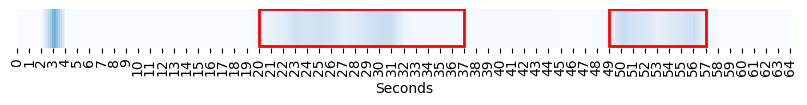

In [23]:
download_blob(processed_video_path, 'tmp_movie.mp4')
_ = show_heatmap(active_rate, analysis_result['events'])
Video('tmp_movie.mp4', embed=True, width=800)